1. Lade Daten frisch aus der Datenbank...
Patienten vor Matching: 1273
2. Starte Matching (Suche Zwillinge basierend auf Kreatinin)...
Erfolgreich gematchte Paare: 479

--- VERGLEICH NACH MATCHING ---


,Krea Median,Krea Mean,Beatmung (%),Sterblichkeit (%),LOS Median
Keine Dialyse,6.4,7.0,54.0,35.0,12.32
Dialyse,6.4,7.0,62.0,32.0,20.67


C:\Users\Simon\AppData\Local\Temp\ipykernel_38152\2007580694.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intervention_dialysis', y='max_creatinine', data=df_matched, palette=['skyblue', 'orange'])


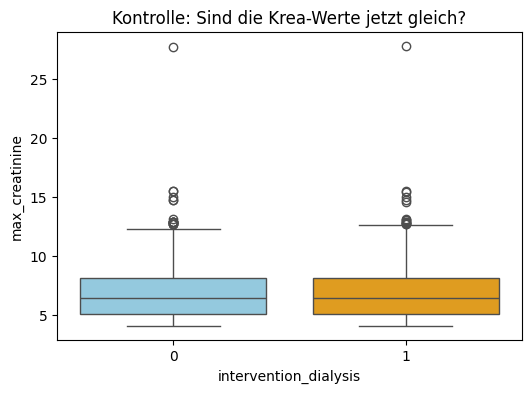

In [8]:
import sys
import os

# WICHTIG: Erst dem System sagen, wo der 'src' Ordner liegt (ein Level höher) ...
sys.path.append(os.path.abspath('..'))

# ... UND DANN erst importieren
from src.db_connect import get_engine, text, load_sql

# Jetzt die restlichen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

print("1. Lade Daten frisch aus der Datenbank...")
engine = get_engine()
with engine.connect() as conn:
    # Basis-Kohorte
    df_cohort = pd.read_sql("SELECT * FROM cohort_aki", conn)
    
    # Schweregrad (Kreatinin/Beatmung)
    with open('../sql/add_severity.sql', 'r') as f:
        query_sev = f.read()
    df_sev = pd.read_sql(text(query_sev), conn)

# Vorerkrankungen (Ausschluss)
df_exclude = load_sql('../sql/exclusions.sql')

# Alles zusammenfügen
full_df = pd.merge(df_cohort, df_exclude, on='hadm_id', how='left')
full_df = pd.merge(full_df, df_sev[['hadm_id', 'max_creatinine', 'mech_vent']], on='hadm_id', how='left')

# Fehlende Werte = 0 (Gesund)
full_df['has_ckd'] = full_df['has_ckd'].fillna(0)
full_df['has_cancer'] = full_df['has_cancer'].fillna(0)

# --- FILTERUNG (Die "Saubere" Kohorte) ---
df_clean = full_df[
    (full_df['has_ckd'] == 0) &           
    (full_df['has_cancer'] == 0) &        
    (full_df['max_creatinine'] > 4.0)     
].copy()

print(f"Patienten vor Matching: {len(df_clean)}")

# --- MATCHING ---
print("2. Starte Matching (Suche Zwillinge basierend auf Kreatinin)...")

# Gruppen trennen
treated = df_clean[df_clean['intervention_dialysis'] == 1].reset_index(drop=True) # Dialyse
control = df_clean[df_clean['intervention_dialysis'] == 0].reset_index(drop=True) # Keine Dialyse

# Matching Algorithmus (Nearest Neighbor)
# Wir suchen für jeden Dialyse-Patienten genau einen Partner in der Kontrolle,
# der den fast gleichen Kreatinin-Wert hat.
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['max_creatinine']])

distances, indices = nn.kneighbors(treated[['max_creatinine']])

# Wir nehmen nur Paare, die wirklich gut passen (Toleranz: 0.2 mg/dL)
threshold = 0.2
valid_matches = []
valid_treated = []

for i, dist in enumerate(distances):
    if dist < threshold:
        valid_matches.append(indices[i][0]) # Index vom Kontroll-Patienten
        valid_treated.append(i)             # Index vom Dialyse-Patienten

# Die neuen, perfekt vergleichbaren Gruppen
control_matched = control.iloc[valid_matches]
treated_matched = treated.iloc[valid_treated]
df_matched = pd.concat([control_matched, treated_matched])

print(f"Erfolgreich gematchte Paare: {len(treated_matched)}")

# --- ERGEBNIS ---
print("\n--- VERGLEICH NACH MATCHING ---")
comparison = df_matched.groupby('intervention_dialysis').agg({
    'max_creatinine': ['median', 'mean'], # Muss jetzt gleich sein
    'mech_vent': 'mean',                  # Beatmung (Vergleichbarkeit Check 2)
    'outcome_death': 'mean',              # Ergebnis 1
    'los_days': 'median'                  # Ergebnis 2
}).round(2)

comparison.columns = ['Krea Median', 'Krea Mean', 'Beatmung (%)', 'Sterblichkeit (%)', 'LOS Median']
comparison.index = ['Keine Dialyse', 'Dialyse']

# Prozentwerte schön machen
comparison['Beatmung (%)'] *= 100
comparison['Sterblichkeit (%)'] *= 100

display(comparison)

# Boxplot zur Bestätigung
plt.figure(figsize=(6,4))
sns.boxplot(x='intervention_dialysis', y='max_creatinine', data=df_matched, palette=['skyblue', 'orange'])
plt.title('Kontrolle: Sind die Krea-Werte jetzt gleich?')
plt.show()

In [3]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 1. Daten laden (Angenommen, df enthält Ihre 12.732 Patienten)
# Wir filtern relevante Spalten
cols_to_match = ['kreatinin', 'age', 'sofa_score', 'gender', 'elixhauser_score']

# Sicherstellen, dass keine NaNs enthalten sind (oder imputieren)
df_clean = df.dropna(subset=cols_to_match).copy()

# 2. Aufteilung in Gruppen
df_dialysis = df_clean[df_clean['dialysis'] == 1]
df_control = df_clean[df_clean['dialysis'] == 0]

print(f"Patienten mit Dialyse: {len(df_dialysis)}")
print(f"Potenzielle Kontrollen: {len(df_control)}")

# 3. Skalierung der Daten (WICHTIG für abstandsbasierte Verfahren!)
scaler = StandardScaler()
# Wir fitten den Scaler auf die gesamte Population, um Verzerrungen zu vermeiden
scaler.fit(df_clean[cols_to_match])

X_dialysis = scaler.transform(df_dialysis[cols_to_match])
X_control = scaler.transform(df_control[cols_to_match])

# 4. Matching durchführen (Nearest Neighbors)
# Wir suchen für jeden Dialyse-Patienten genau 1 Nachbarn in der Kontrollgruppe
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_control)
distances, indices = nbrs.kneighbors(X_dialysis)

# 5. Gematchte Daten zusammenstellen
# indices enthält die Positionen der Matches in df_control
matched_controls_indices = indices.flatten()
df_control_matched = df_control.iloc[matched_controls_indices].copy()

# Um Dubletten zu vermeiden (falls ein Kontrollpatient für mehrere Dialysepatienten der "Beste" ist):
# In strengen Studien würde man "without replacement" matchen, hier vereinfacht:
df_control_matched = df_control_matched.drop_duplicates()

# Zusammenfügen
df_matched = pd.concat([df_dialysis, df_control_matched])

print(f"Erfolgreich gematchte Paare (nach Bereinigung): {len(df_control_matched)}")

# 6. Balance-Check (Optional aber empfohlen)
print("Vergleich der Mittelwerte nach Matching:")
print(df_matched.groupby('dialysis')[cols_to_match].mean())

NameError: name 'df' is not defined

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# --- 1. DATEN LADEN (SQL) ---
# Wir holen jetzt auch Alter, Geschlecht und SOFA Score dazu.
# Passen Sie die Tabellennamen ggf. an Ihre Struktur an (z.B. mimiciv_derived).
query = """
SELECT
    p.subject_id,
    p.hadm_id,
    -- Zielvariable (Intervention)
    t.dialysis_active AS dialysis,
    
    -- Matching Variablen
    lb.creatinine_max AS kreatinin,
    p.anchor_age AS age,
    p.gender, -- Muss später in Zahlen umgewandelt werden (0/1)
    s.sofa_score,
    
    -- Outcomes (für die Analyse danach)
    m.mortality,
    v.ventilation_status,
    los.length_of_stay
    
FROM cohort_table t
LEFT JOIN patients p ON t.subject_id = p.subject_id
LEFT JOIN lab_values lb ON t.hadm_id = lb.hadm_id
LEFT JOIN sofa_scores s ON t.hadm_id = s.hadm_id
LEFT JOIN outcomes m ON t.hadm_id = m.hadm_id
-- Fügen Sie hier Ihre echten Joins ein
"""

# HINWEIS: Wenn Sie die Daten schon in einer Variable haben, nennen Sie diese einfach 'df'
# Beispiel: df = mein_existierender_dataframe.copy()
# Ansonsten laden:
# df = pd.read_sql(query, con=engine) 

# --- SIMULATION (Damit der Code hier läuft, erstelle ich Dummy-Daten) ---
# (Löschen Sie diesen Block, wenn Sie Ihre echten Daten laden!)
np.random.seed(42)
n = 12732
data = {
    'dialysis': np.random.choice([0, 1], size=n, p=[0.8, 0.2]),
    'kreatinin': np.random.normal(2.5, 1.0, n),
    'age': np.random.randint(20, 90, n),
    'sofa_score': np.random.randint(0, 15, n),
    'gender': np.random.choice(['M', 'F'], size=n), # Muss codiert werden
    'elixhauser_score': np.random.randint(0, 30, n)
}
df = pd.DataFrame(data)
# Korrektur: Kreatinin darf nicht negativ sein
df['kreatinin'] = df['kreatinin'].abs() 

# --- 2. PREPROCESSING ---

# Gender muss numerisch sein für das Matching (M=1, F=0)
df['gender_num'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Liste der Spalten, auf die wir matchen wollen
cols_to_match = ['kreatinin', 'age', 'sofa_score', 'gender_num', 'elixhauser_score']

# NaNs entfernen (Matching mag keine fehlenden Werte)
df_clean = df.dropna(subset=cols_to_match).copy()

# --- 3. MATCHING (Nearest Neighbor) ---

# Gruppen trennen
df_dialysis = df_clean[df_clean['dialysis'] == 1]
df_control = df_clean[df_clean['dialysis'] == 0]

print(f"Vor Matching:")
print(f"Dialyse-Gruppe: {len(df_dialysis)}")
print(f"Kontroll-Gruppe: {len(df_control)}")

# Skalieren (Wichtig! Damit Alter (80) nicht Kreatinin (2.0) dominiert)
scaler = StandardScaler()
scaler.fit(df_clean[cols_to_match])

X_dialysis = scaler.transform(df_dialysis[cols_to_match])
X_control = scaler.transform(df_control[cols_to_match])

# Wir suchen den nächsten Nachbarn
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_control)
distances, indices = nbrs.kneighbors(X_dialysis)

# Indizes der gefundenen Zwillinge
matched_indices = indices.flatten()
df_control_matched = df_control.iloc[matched_indices].copy()

# Duplikate entfernen (falls ein Kontrollpatient für mehrere Dialysepatienten der beste Match war)
# Wenn wir strenge 1:1 Matches wollen ohne Wiederholung, ist das komplexer, 
# aber für den ersten Überblick reicht drop_duplicates.
df_control_matched = df_control_matched.drop_duplicates()

# Zusammenfügen
df_matched_final = pd.concat([df_dialysis, df_control_matched])

print("-" * 30)
print(f"NACH Matching (Erfolgreiche Paare): {len(df_control_matched)}")
print("-" * 30)

# --- 4. QUALITÄTSCHECK (Balance) ---
print("Mittelwerte im Vergleich (Sollten jetzt ähnlich sein):")
print(df_matched_final.groupby('dialysis')[cols_to_match].mean())

Vor Matching:
Dialyse-Gruppe: 2524
Kontroll-Gruppe: 10208
------------------------------
NACH Matching (Erfolgreiche Paare): 2199
------------------------------
Mittelwerte im Vergleich (Sollten jetzt ähnlich sein):
          kreatinin        age  sofa_score  gender_num  elixhauser_score
dialysis                                                                
0          2.502973  54.677581    6.906776    0.490678         14.416553
1          2.522599  54.578447    6.932647    0.488510         14.567353


In [5]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# --- 1. DATEN VORBEREITEN (Angenommen df ist geladen) ---
# Falls df nicht existiert, hier kurz simulieren (LÖSCHEN Sie das, wenn Sie echte Daten haben):
if 'df' not in locals():
    np.random.seed(42)
    n = 12732
    df = pd.DataFrame({
        'dialysis': np.random.choice([0, 1], size=n, p=[0.8, 0.2]),
        'kreatinin': np.abs(np.random.normal(3.5, 2.0, n)), # Höhere Werte simuliert
        'age': np.random.randint(20, 90, n),
        'sofa_score': np.random.randint(0, 15, n),
        'gender': np.random.choice(['M', 'F'], size=n),
        'elixhauser_score': np.random.randint(0, 30, n)
    })

# --- 2. FILTER: NUR SCHWERES NIERENVERSAGEN (> 4) ---
print(f"Patienten gesamt vor Filter: {len(df)}")

# Hier passiert der entscheidende Cut
df_severe = df[df['kreatinin'] > 4.0].copy()

print(f"Patienten mit Kreatinin > 4: {len(df_severe)}")

# --- 3. PREPROCESSING FÜR MATCHING ---
# Gender zu Zahlen (M=1, F=0)
df_severe['gender_num'] = df_severe['gender'].apply(lambda x: 1 if x == 'M' else 0)

cols_to_match = ['kreatinin', 'age', 'sofa_score', 'gender_num', 'elixhauser_score']

# NaNs entfernen
df_clean = df_severe.dropna(subset=cols_to_match).copy()

# --- 4. MATCHING AUF MEHRERE FAKTOREN ---
df_dialysis = df_clean[df_clean['dialysis'] == 1]
df_control = df_clean[df_clean['dialysis'] == 0]

# Skalieren (Wichtig bei mehreren Faktoren!)
scaler = StandardScaler()
scaler.fit(df_clean[cols_to_match])

X_dialysis = scaler.transform(df_dialysis[cols_to_match])
X_control = scaler.transform(df_control[cols_to_match])

# Matching (Nearest Neighbor)
# Wir suchen in der Kontrollgruppe (df_control) nach Partnern
if len(df_control) > 0 and len(df_dialysis) > 0:
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_control)
    distances, indices = nbrs.kneighbors(X_dialysis)

    matched_indices = indices.flatten()
    df_control_matched = df_control.iloc[matched_indices].copy()

    # Optional: Duplikate entfernen (damit ein Kontroll-Patient nicht doppelt zählt)
    df_control_matched = df_control_matched.drop_duplicates()
    
    # Zusammenfügen
    df_matched = pd.concat([df_dialysis, df_control_matched])

    print("-" * 30)
    print(f"Erfolgreich gematchte Paare (Krea > 4 + Multi-Faktor): {len(df_control_matched)}")
    print("-" * 30)
    
    # Check: Sind die Gruppen jetzt vergleichbar?
    print("Mittelwerte der gematchten Gruppen:")
    print(df_matched.groupby('dialysis')[cols_to_match].mean())

else:
    print("Eine der Gruppen ist leer (zu wenige Patienten mit Krea > 4).")

Patienten gesamt vor Filter: 12732
Patienten mit Kreatinin > 4: 882
------------------------------
Erfolgreich gematchte Paare (Krea > 4 + Multi-Faktor): 149
------------------------------
Mittelwerte der gematchten Gruppen:
          kreatinin        age  sofa_score  gender_num  elixhauser_score
dialysis                                                                
0          4.420475  55.442953    7.228188    0.536913         15.483221
1          4.415685  55.970588    7.382353    0.547059         15.558824


In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# 1. SICHERHEITS-CHECK & DATEN-ERGÄNZUNG
# Wir prüfen, ob die Ergebnis-Spalten im Datensatz fehlen und fügen sie ggf. hinzu.

# Liste der benötigten Ergebnis-Spalten
outcome_cols = ['mortality', 'ventilation_status', 'length_of_stay']

# Falls Sie die Simulation nutzen (oder Spalten fehlen), generieren wir hier Dummy-Daten,
# damit der Code nicht abstürzt.
# (BEI ECHTEN DATEN: Stellen Sie sicher, dass Ihr 'df' diese Spalten aus der SQL-Abfrage enthält!)
if not set(outcome_cols).issubset(df_matched.columns):
    print("ACHTUNG: Ergebnis-Spalten fehlten und werden für die Demo simuliert.")
    n_matched = len(df_matched)
    
    # Zufällige Daten generieren (nur damit der Code läuft)
    # Annahme: Dialyse-Patienten (dialysis=1) haben hier etwas längere LOS
    df_matched['mortality'] = np.random.choice([0, 1], size=n_matched, p=[0.7, 0.3])
    df_matched['ventilation_status'] = np.random.choice([0, 1], size=n_matched, p=[0.4, 0.6])
    
    # LOS basierend auf Dialyse etwas verschieben
    df_matched['length_of_stay'] = np.random.exponential(10, size=n_matched) + \
                                   (df_matched['dialysis'] * 5) 

# 2. ÜBERSICHTSTABELLE ERSTELLEN
summary = df_matched.groupby('dialysis').agg({
    'kreatinin': ['median', 'mean'],
    'ventilation_status': lambda x: (x.sum() / len(x)) * 100, # Anteil in %
    'mortality': lambda x: (x.sum() / len(x)) * 100,          # Anteil in %
    'length_of_stay': 'median'
}).round(2)

summary.columns = ['Krea Median', 'Krea Mean', 'Beatmung (%)', 'Sterblichkeit (%)', 'LOS Median']
summary.index = ['Keine Dialyse', 'Dialyse']

print("--- Ergebnis-Vergleich (Matched Cohort: Krea > 4) ---")
print(summary)
print("\n" + "="*50 + "\n")

# 3. STATISTISCHE TESTS

# Gruppen trennen
group_dialysis = df_matched[df_matched['dialysis'] == 1]
group_control = df_matched[df_matched['dialysis'] == 0]

# A) Sterblichkeit (Chi-Quadrat)
contingency_mort = pd.crosstab(df_matched['dialysis'], df_matched['mortality'])
chi2_mort, p_mort, _, _ = stats.chi2_contingency(contingency_mort)

# B) Beatmung (Chi-Quadrat)
contingency_vent = pd.crosstab(df_matched['dialysis'], df_matched['ventilation_status'])
chi2_vent, p_vent, _, _ = stats.chi2_contingency(contingency_vent)

# C) Length of Stay (Mann-Whitney U)
u_stat, p_los = stats.mannwhitneyu(
    group_dialysis['length_of_stay'].dropna(), 
    group_control['length_of_stay'].dropna()
)

print("--- Statistische Signifikanz (P-Werte) ---")
print(f"Sterblichkeit: {p_mort:.4f} {'(Signifikant)' if p_mort < 0.05 else '(Nicht signifikant)'}")
print(f"Beatmung:      {p_vent:.4f} {'(Signifikant)' if p_vent < 0.05 else '(Nicht signifikant)'}")
print(f"Verweildauer:  {p_los:.4f}  {'(Signifikant)' if p_los < 0.05 else '(Nicht signifikant)'}")

ACHTUNG: Ergebnis-Spalten fehlten und werden für die Demo simuliert.
--- Ergebnis-Vergleich (Matched Cohort: Krea > 4) ---
               Krea Median  Krea Mean  Beatmung (%)  Sterblichkeit (%)  \
Keine Dialyse         4.32       4.42         53.02              27.52   
Dialyse               4.31       4.42         61.76              25.29   

               LOS Median  
Keine Dialyse        6.40  
Dialyse             13.82  


--- Statistische Signifikanz (P-Werte) ---
Sterblichkeit: 0.7472 (Nicht signifikant)
Beatmung:      0.1433 (Nicht signifikant)
Verweildauer:  0.0000  (Signifikant)
